In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
# Ruta de la carpeta de imágenes y del archivo CSV
ruta_imagenes = "/content/drive/MyDrive/Semestre 9/Visión por Computador/Ejericicio_Mangos/MangoMass/images"
archivo_csv = "/content/drive/MyDrive/Semestre 9/Visión por Computador/Ejericicio_Mangos/MangoMass/Harumanis_mango_weight.csv"

In [3]:
datos = pd.read_csv(archivo_csv)
peso_por_imagen = dict(zip(datos['no'], datos['weight']))

In [4]:
# Listado de archivos de imagen en la carpeta
archivos_imagenes = [img for img in os.listdir(ruta_imagenes) if os.path.isfile(os.path.join(ruta_imagenes, img))]
imagenes_con_peso = []

In [5]:
# Procesar cada imagen que tenga un peso asociado en el CSV
for nombre_imagen in archivos_imagenes:
    if nombre_imagen in peso_por_imagen:
        peso = peso_por_imagen[nombre_imagen]

        ruta_imagen = os.path.join(ruta_imagenes, nombre_imagen)
        imagen = cv2.imread(ruta_imagen)

        if imagen is not None:
            imagenes_con_peso.append((nombre_imagen, imagen, peso))
        else:
            print(f"No se pudo cargar la imagen: {nombre_imagen}")

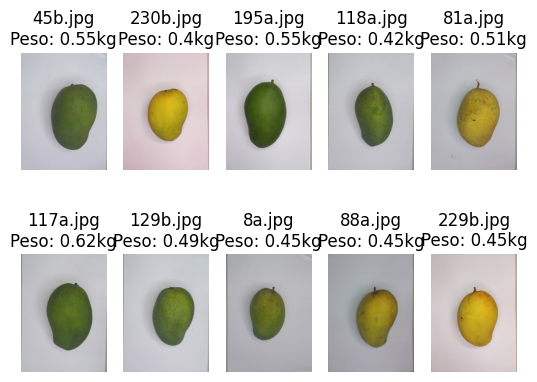

Total de imágenes procesadas: 546


In [6]:
# Mostrar algunas imágenes con sus pesos
for idx, (nombre_imagen, imagen, peso) in enumerate(imagenes_con_peso[:10]):
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, idx + 1)
    plt.imshow(imagen_rgb)
    plt.title(f"{nombre_imagen}\nPeso: {peso}kg")
    plt.axis('off')
plt.show()

print(f"Total de imágenes procesadas: {len(imagenes_con_peso)}")

In [7]:
# Función de preprocesamiento de imágenes
def procesar_imagen(imagen):
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    imagen_ecualizada = cv2.equalizeHist(imagen_gris)
    _, imagen_umbral = cv2.threshold(imagen_ecualizada, 128, 255, cv2.THRESH_BINARY)
    kernel_morfo = np.ones((3, 3), np.uint8)
    imagen_morfologica = cv2.morphologyEx(imagen_umbral, cv2.MORPH_CLOSE, kernel_morfo)
    return imagen_morfologica

In [8]:
# Función para extraer características
def extraer_caracteristicas(imagen):
    imagen_procesada = procesar_imagen(imagen)
    caracteristicas_hog, _ = hog(imagen_procesada, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    momentos = cv2.moments(imagen_procesada)
    momentos_hu = cv2.HuMoments(momentos).flatten()

    contornos, _ = cv2.findContours(imagen_procesada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contornos) > 0:
        contorno = contornos[0]
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)

        compactacion = (perimetro ** 2) / area if area > 0 else 0
        excentricidad = momentos['mu20'] / momentos['mu02'] if momentos['mu02'] != 0 else 0
    else:
        compactacion = 0
        excentricidad = 0

    return np.hstack([caracteristicas_hog, momentos_hu, compactacion, excentricidad])

In [9]:
# Preparar datos para el modelo
X = []
y = []
for archivo_imagen in archivos_imagenes:
    if archivo_imagen in peso_por_imagen:
        peso = peso_por_imagen[archivo_imagen]

        ruta_img = os.path.join(ruta_imagenes, archivo_imagen)
        img = cv2.imread(ruta_img)

        if img is not None:
            caracteristicas = extraer_caracteristicas(img)
            X.append(caracteristicas)
            y.append(peso)
        else:
            print(f"No se pudo leer la imagen: {archivo_imagen}")

In [10]:
# Convertir listas a arrays numpy
X = np.array(X)
y = np.array(y)

In [11]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Inicializar y entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [13]:
# Predecir en el conjunto de prueba
y_pred = modelo.predict(X_test)

In [14]:
# Calcular el error absoluto medio
error_absoluto = mean_absolute_error(y_test, y_pred)
print(f"Error Absoluto Medio: {error_absoluto}")

Error Absoluto Medio: 0.029414315616523353


In [15]:
# Mostrar predicciones y valores reales
for idx in range(len(y_test)):
    print(f"Peso real: {y_test[idx]} kg, Peso predicho: {y_pred[idx]:.2f} kg")

Peso real: 0.39 kg, Peso predicho: 0.40 kg
Peso real: 0.48 kg, Peso predicho: 0.47 kg
Peso real: 0.5 kg, Peso predicho: 0.45 kg
Peso real: 0.47 kg, Peso predicho: 0.47 kg
Peso real: 0.55 kg, Peso predicho: 0.52 kg
Peso real: 0.45 kg, Peso predicho: 0.48 kg
Peso real: 0.45 kg, Peso predicho: 0.46 kg
Peso real: 0.45 kg, Peso predicho: 0.44 kg
Peso real: 0.3 kg, Peso predicho: 0.30 kg
Peso real: 0.35 kg, Peso predicho: 0.38 kg
Peso real: 0.49 kg, Peso predicho: 0.48 kg
Peso real: 0.45 kg, Peso predicho: 0.49 kg
Peso real: 0.45 kg, Peso predicho: 0.42 kg
Peso real: 0.3 kg, Peso predicho: 0.33 kg
Peso real: 0.4 kg, Peso predicho: 0.37 kg
Peso real: 0.38 kg, Peso predicho: 0.41 kg
Peso real: 0.4 kg, Peso predicho: 0.40 kg
Peso real: 0.42 kg, Peso predicho: 0.43 kg
Peso real: 0.35 kg, Peso predicho: 0.40 kg
Peso real: 0.47 kg, Peso predicho: 0.51 kg
Peso real: 0.54 kg, Peso predicho: 0.55 kg
Peso real: 0.39 kg, Peso predicho: 0.44 kg
Peso real: 0.35 kg, Peso predicho: 0.44 kg
Peso real: 0.44 